# Preprocessing Workflow Structure

So let's get our hands dirty. First things first, it's always good to know which interfaces you want to use in your workflow and in which order you want to execute them. For the preprocessing workflow, I recommend that we use the following nodes:

     1. Gunzip (Nipype)
     2. Drop Dummy Scans (FSL)
     3. Slice Time Correction (SPM)
     4. Motion Correction (SPM)
     5. Artifact Detection
     6. Segmentation (SPM)
     7. Coregistration (FSL)
     8. Smoothing (FSL)
     9. Apply Binary Mask (FSL)
    10. Remove Linear Trends (Nipype)

## Imports

In [86]:
from nipype import Node, Workflow, Merge, IdentityInterface, SelectFiles, MapNode
from nipype.interfaces.io import DataSink
import nibabel as nb
import matplotlib.pyplot as plt
from nipype.interfaces.fsl import ExtractROI, MCFLIRT, FLIRT, Threshold, ApplyMask
from nipype.interfaces.spm import SliceTiming, NewSegment
from nilearn import image as nli
from nilearn.plotting import plot_stat_map, plot_anat, plot_epi
from nipype.algorithms.rapidart import ArtifactDetect
from nipype.algorithms.confounds import TSNR
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth
from IPython.display import Image, SVG
import numpy as np

## Create Nodes

Let's create all the nodes that we need! Make sure to specify all relevant inputs and keep in mind which ones you later on need to connect in your pipeline.

### Drop Dummy Scans

The functional images of this dataset were recorded with 4 dummy scans at the beginning (see the [corresponding publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3641991/)). But those dummy scans were not yet taken out from the functional images.

In [9]:
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

### IdentityInterface 
Specify where the input data can be found & where and how to save the output data.

In [11]:
subject_list = ['07', '08']
task_list = ['1']
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

## Datainput with `SelectFiles` and `iterables` 

For this, we need [`SelectFiles`](../../../nipype_tutorial/notebooks/basic_data_input.ipynb#SelectFiles) and [`iterables`](../../../nipype_tutorial/notebooks/basic_iteration.ipynb)! It's rather simple, specify a template and fill-up the placeholder variables.

In [23]:
subject_list = ['%02d'%i for i in range(1,23)]
task_list = ['1', '2', '3', '4']
# String template with {}-based strings
templates = {'anat': 'sub-{subject_id}/ses-test/anat/sub-{subject_id}_ses-test_anat_sT1W.nii',
             'func': 'sub-{subject_id}/ses-test/func/sub-{subject_id}_ses-test_session{task_id}_bold.nii'}
# Create SelectFiles node
selectfiles = Node(SelectFiles(templates,
                      base_directory='/home/neuro/Data/Visual_search_task/BIDS_data',
                      sort_filelist=True),
          name='selectfiles')
selectfiles.iterables = [('subject_id', subject_list), ('task_id', task_list)]

### Slice Time Correction

Now to the next step. Let's us SPM's `SliceTiming` to correct for slice wise acquisition of the volumes. As a reminder, the tutorial dataset was recorded...
- with a time repetition (TR) of 2.5 seconds
- with 30 slices per volume
- in an interleaved fashion, i.e. slice order is [1, 3, 5, 7, ..., 2, 4, 6, ..., 30]
- with a time acquisition (TA) of 2.4167 seconds, i.e. `TR-(TR/num_slices)`

In [24]:
slice_order = list(range(1, 32, 2)) + list(range(2, 32, 2))
slicetime = Node(SliceTiming(num_slices=31,
                             ref_slice=2,
                             slice_order=slice_order,
                             time_repetition=2,
                             time_acquisition=2-(2/31)),
                 name='slicetime')

### Motion Correction

To correct for motion in the scanner, we will be using FSL's `MCFLIRT`.

In [25]:
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True),
               name="mcflirt")

### Artifact Detection

We will use the really cool and useful `ArtifactDetection` tool from Nipype to detect motion and intensity outliers in the functional images. The interface is initiated as follows:

In [26]:
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

The parameters above mean the following:
- `norm_threshold` - Threshold to use to detect motion-related outliers when composite motion is being used
- `zintensity_threshold` - Intensity Z-threshold use to detection images that deviate from the mean
- `mask_type` - Type of mask that should be used to mask the functional data. *spm_global* uses an spm_global like calculation to determine the brain mask
- `parameter_source` - Source of movement parameters
- `use_differences` - If you want to use differences between successive motion (first element) and intensity parameter (second element) estimates in order to determine outliers

### Segmentation of anatomical image

Now let's work on the anatomical image. In particular, let's use SPM's `NewSegment` to create probability maps for the gray matter, white matter tissue and CSF.

In [32]:
# Use the following tissue specification to get a GM and WM probability map
tpm_img ='/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'
tissue1 = ((tpm_img, 1), 1, (True,False), (False, False))
tissue2 = ((tpm_img, 2), 1, (True,False), (False, False))
tissue3 = ((tpm_img, 3), 2, (True,False), (False, False))
tissue4 = ((tpm_img, 4), 3, (False,False), (False, False))
tissue5 = ((tpm_img, 5), 4, (False,False), (False, False))
tissue6 = ((tpm_img, 6), 2, (False,False), (False, False))
tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
segment = Node(NewSegment(tissues=tissues), name='segment')

### Compute Coregistration Matrix

As a next step, we will make sure that the functional images are coregistered to the anatomical image. For this, we will use FSL's `FLIRT` function. As we just created a white matter probability map, we can use this together with the Boundary-Based Registration (BBR) cost function to optimize the image coregistration. As some helpful notes...
- use a degree of freedom of 6
- specify the cost function as `bbr`
- use the `schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch'`

In [38]:
coreg = Node(FLIRT(dof=6,
                   cost='bbr',
                   schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch',
                   output_type='NIFTI'),
             name="coreg")

As mentioned above, the `bbr` routine can use the subject-specific white matter probability map to guide the coregistration. But for this, we need to create a binary mask out of the WM probability map. This can easily be done by FSL's `Threshold` interface.

In [47]:
# Threshold - Threshold WM probability image
threshold_WM = Node(Threshold(thresh=0.5,
                              args='-bin',
                              output_type='NIFTI'),
                name="threshold_WM")

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[1][0]

Now, to select the WM probability map that the `NewSegment` node created, we need some helper function. Because the output field `partial_volume_files` form the segmentation node, will give us a list of files, i.e. `[[GM_prob], [WM_prob], [], [], [], []]`. Therefore, using the following function, we can select only the last element of this list.

### Apply Coregistration Matrix to functional image

Now that we know the coregistration matrix to correctly overlay the functional mean image on the subject-specific anatomy, we need to apply to coregistration to the whole time series. This can be achieved with FSL's `FLIRT` as follows:

In [58]:
# Specify the isometric voxel resolution you want after coregistration
desired_voxel_iso = 4
# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=desired_voxel_iso,
                       output_type='NIFTI'),
                 name="applywarp")

**<span style="color:red">Important</span>**: As you can see above, we also specified a variable `desired_voxel_iso`. This is very important at this stage, otherwise `FLIRT` will transform your functional images to a resolution of the anatomical image, which will dramatically increase the file size (e.g. to 1-10GB per file). If you don't want to change the voxel resolution, use the additional parameter `no_resample=True`. Important, for this to work, you still need to define `apply_isoxfm`.

### Smoothing

Next step is image smoothing. The most simple way to do this is to use FSL's or SPM's `Smooth` function. But for learning purposes, let's use FSL's `SUSAN` workflow as it is implemented in Nipype. Note that this time, we are importing a workflow instead of an interface.

If you type `create_susan_smooth?` you can see how to specify the input variables to the susan workflow. In particular, they are...
- `fwhm`: set this value to 4 (or whichever value you want)
- `mask_file`: will be created in a later step
- `in_file`: will be handled while connection to other nodes in the preproc workflow

In [65]:
susan = create_susan_smooth(name='susan')
susan.inputs.inputnode.fwhm = 8

### Create Binary Mask

There are many possible approaches on how you can mask your functional images. One of them is not at all, one is with a simple brain mask and one that only considers certain kind of brain tissue, e.g. gray matter.

For the current example, we want to create a dilated gray matter mask. For this purpose we need to:
1. Resample the gray matter probability map to the same resolution as the functional images
2. Threshold this resampled probability map at a specific value
3. Dilate this mask by some voxels to make the mask less conservative and more inclusive

The first step can be done in many ways (eg. using freesurfer's `mri_convert`, `nibabel`) but in our case, we will use FSL's `FLIRT`. The trick is to use the probability mask, as input file and a reference file.

In [66]:
# Initiate resample node
resample = Node(FLIRT(apply_isoxfm=desired_voxel_iso,
                      output_type='NIFTI'),
                name="resample")

The second and third step can luckily be done with just one node. We can take almost the same `Threshold` node as above. We just need to add another additional argument: `-dilF` - which applies a maximum filtering of all voxels.

In [67]:
# Threshold - Threshold GM probability image
mask_GM = Node(Threshold(thresh=0.5,
                         args='-bin -dilF',
                         output_type='NIFTI'),
                name="mask_GM")

# Select GM segmentation file from segmentation output
def get_gm(files):
    return files[0][0]

To apply the mask to the smoothed functional images, we will use FSL's `ApplyMask` interface.

**Important:** The susan workflow gives out a list of files, i.e. `[smoothed_func.nii]` instead of just the filename directly. If we would use a normal `Node` for `ApplyMask` this would lead to the following error:

    TraitError: The 'in_file' trait of an ApplyMaskInput instance must be an existing file name, but a value of ['/output/work_preproc/susan/smooth/mapflow/_smooth0/asub-07_ses-test_task-fingerfootlips_bold_mcf_flirt_smooth.nii.gz'] <class 'list'> was specified.


To prevent this we will be using a `MapNode` and specify the `in_file` as it's iterfield. Like this, the node is capable to handle a list of inputs as it will know that it has to apply itself iteratively to the list of inputs.

In [74]:
mask_func = MapNode(ApplyMask(output_type='NIFTI'),
                    name="mask_func", 
                    iterfield=["in_file"])

### Remove linear trends in functional images

Last but not least. Let's use Nipype's `TSNR` module to remove linear and quadratic trends in the functionally smoothed images. For this, you only have to specify the `regress_poly` parameter in the node initiation.

In [78]:
detrend = Node(TSNR(regress_poly=2), name="detrend")

## Data output with `DataSink`

The results look fine, but we don't need all those temporary files. So let's use Datasink to keep only those files that we actually need for the 1st and 2nd level analysis.

In [106]:
output_folder = 'preproc_result'
datasink = Node(DataSink(base_directory='/home/neuro/Result/Visual_search_task/preproc_working_dir/',
                         container=output_folder), name="datasink")

In [108]:
## Use the following substitutions for the DataSink output
substitutions = [('asub', 'sub'),
                 ('_ses-test_task-fingerfootlips_bold_roi_mcf', ''),
                 ('.nii.gz.par', '.par'),
                 ]

# To get rid of the folder '_subject_id_07' and renaming detrend
substitutions += [('_subject_id_%s/detrend' % s,
                   '_subject_id_%s/sub-%s_detrend' % (s, s)) for s in subject_list]
substitutions += [('_subject_id_%s/' % s, '') for s in subject_list]
datasink.inputs.substitutions = substitutions

### Workflow

And for this, we first need to create a workflow:

In [107]:
preproc = Workflow(base_dir='/home/neuro/Result/Visual_search_task/preproc_working_dir', name='preproc')

In [109]:
preproc.connect([(selectfiles, slicetime, [('func', 'in_files')]),
                  (slicetime, mcflirt, [('timecorrected_files', 'in_file')]),
                  (mcflirt, art, [('out_file', 'realigned_files'), ('par_file', 'realignment_parameters')]), 
                  (selectfiles, segment, [('anat', 'channel_files')]), 
                  (selectfiles, coreg, [('anat', 'reference')]), (mcflirt, coreg, [('mean_img', 'in_file')]), 
                  (segment, threshold_WM, [(('native_class_images', get_wm), 'in_file')]), 
                  (threshold_WM, coreg, [('out_file', 'wm_seg')]), 
                  (mcflirt, applywarp, [('out_file', 'in_file')]),
                  (coreg, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                  (selectfiles, applywarp, [('anat', 'reference')]), 
                  (applywarp, susan, [('out_file', 'inputnode.in_files')]), 
                  (segment, resample, [(('native_class_images', get_gm), 'in_file'), 
                                        (('native_class_images', get_gm), 'reference')]), 
                  (resample, mask_GM, [('out_file', 'in_file')]), 
                  (mask_GM, susan, [('out_file', 'inputnode.mask_file')]), 
                  (susan, mask_func, [('outputnode.smoothed_files', 'in_file')]),
                  (mask_GM, mask_func, [('out_file', 'mask_file')]), 
                  (mask_func, detrend, [('out_file', 'in_file')])])
preproc.connect([(art, datasink, [('outlier_files', 'outlier_files'),
                                  ('plot_files', 'plot_files')]),
                 (mcflirt, datasink, [('par_file', 'par')]),
                 (detrend, datasink, [('detrended_file', 'func')]),
                 ])

## Visualize the workflow

Now that we're done. Let's look at the workflow that we just created.

211113-07:59:42,137 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/graph.png (graph2use=flat, simple_form=True).


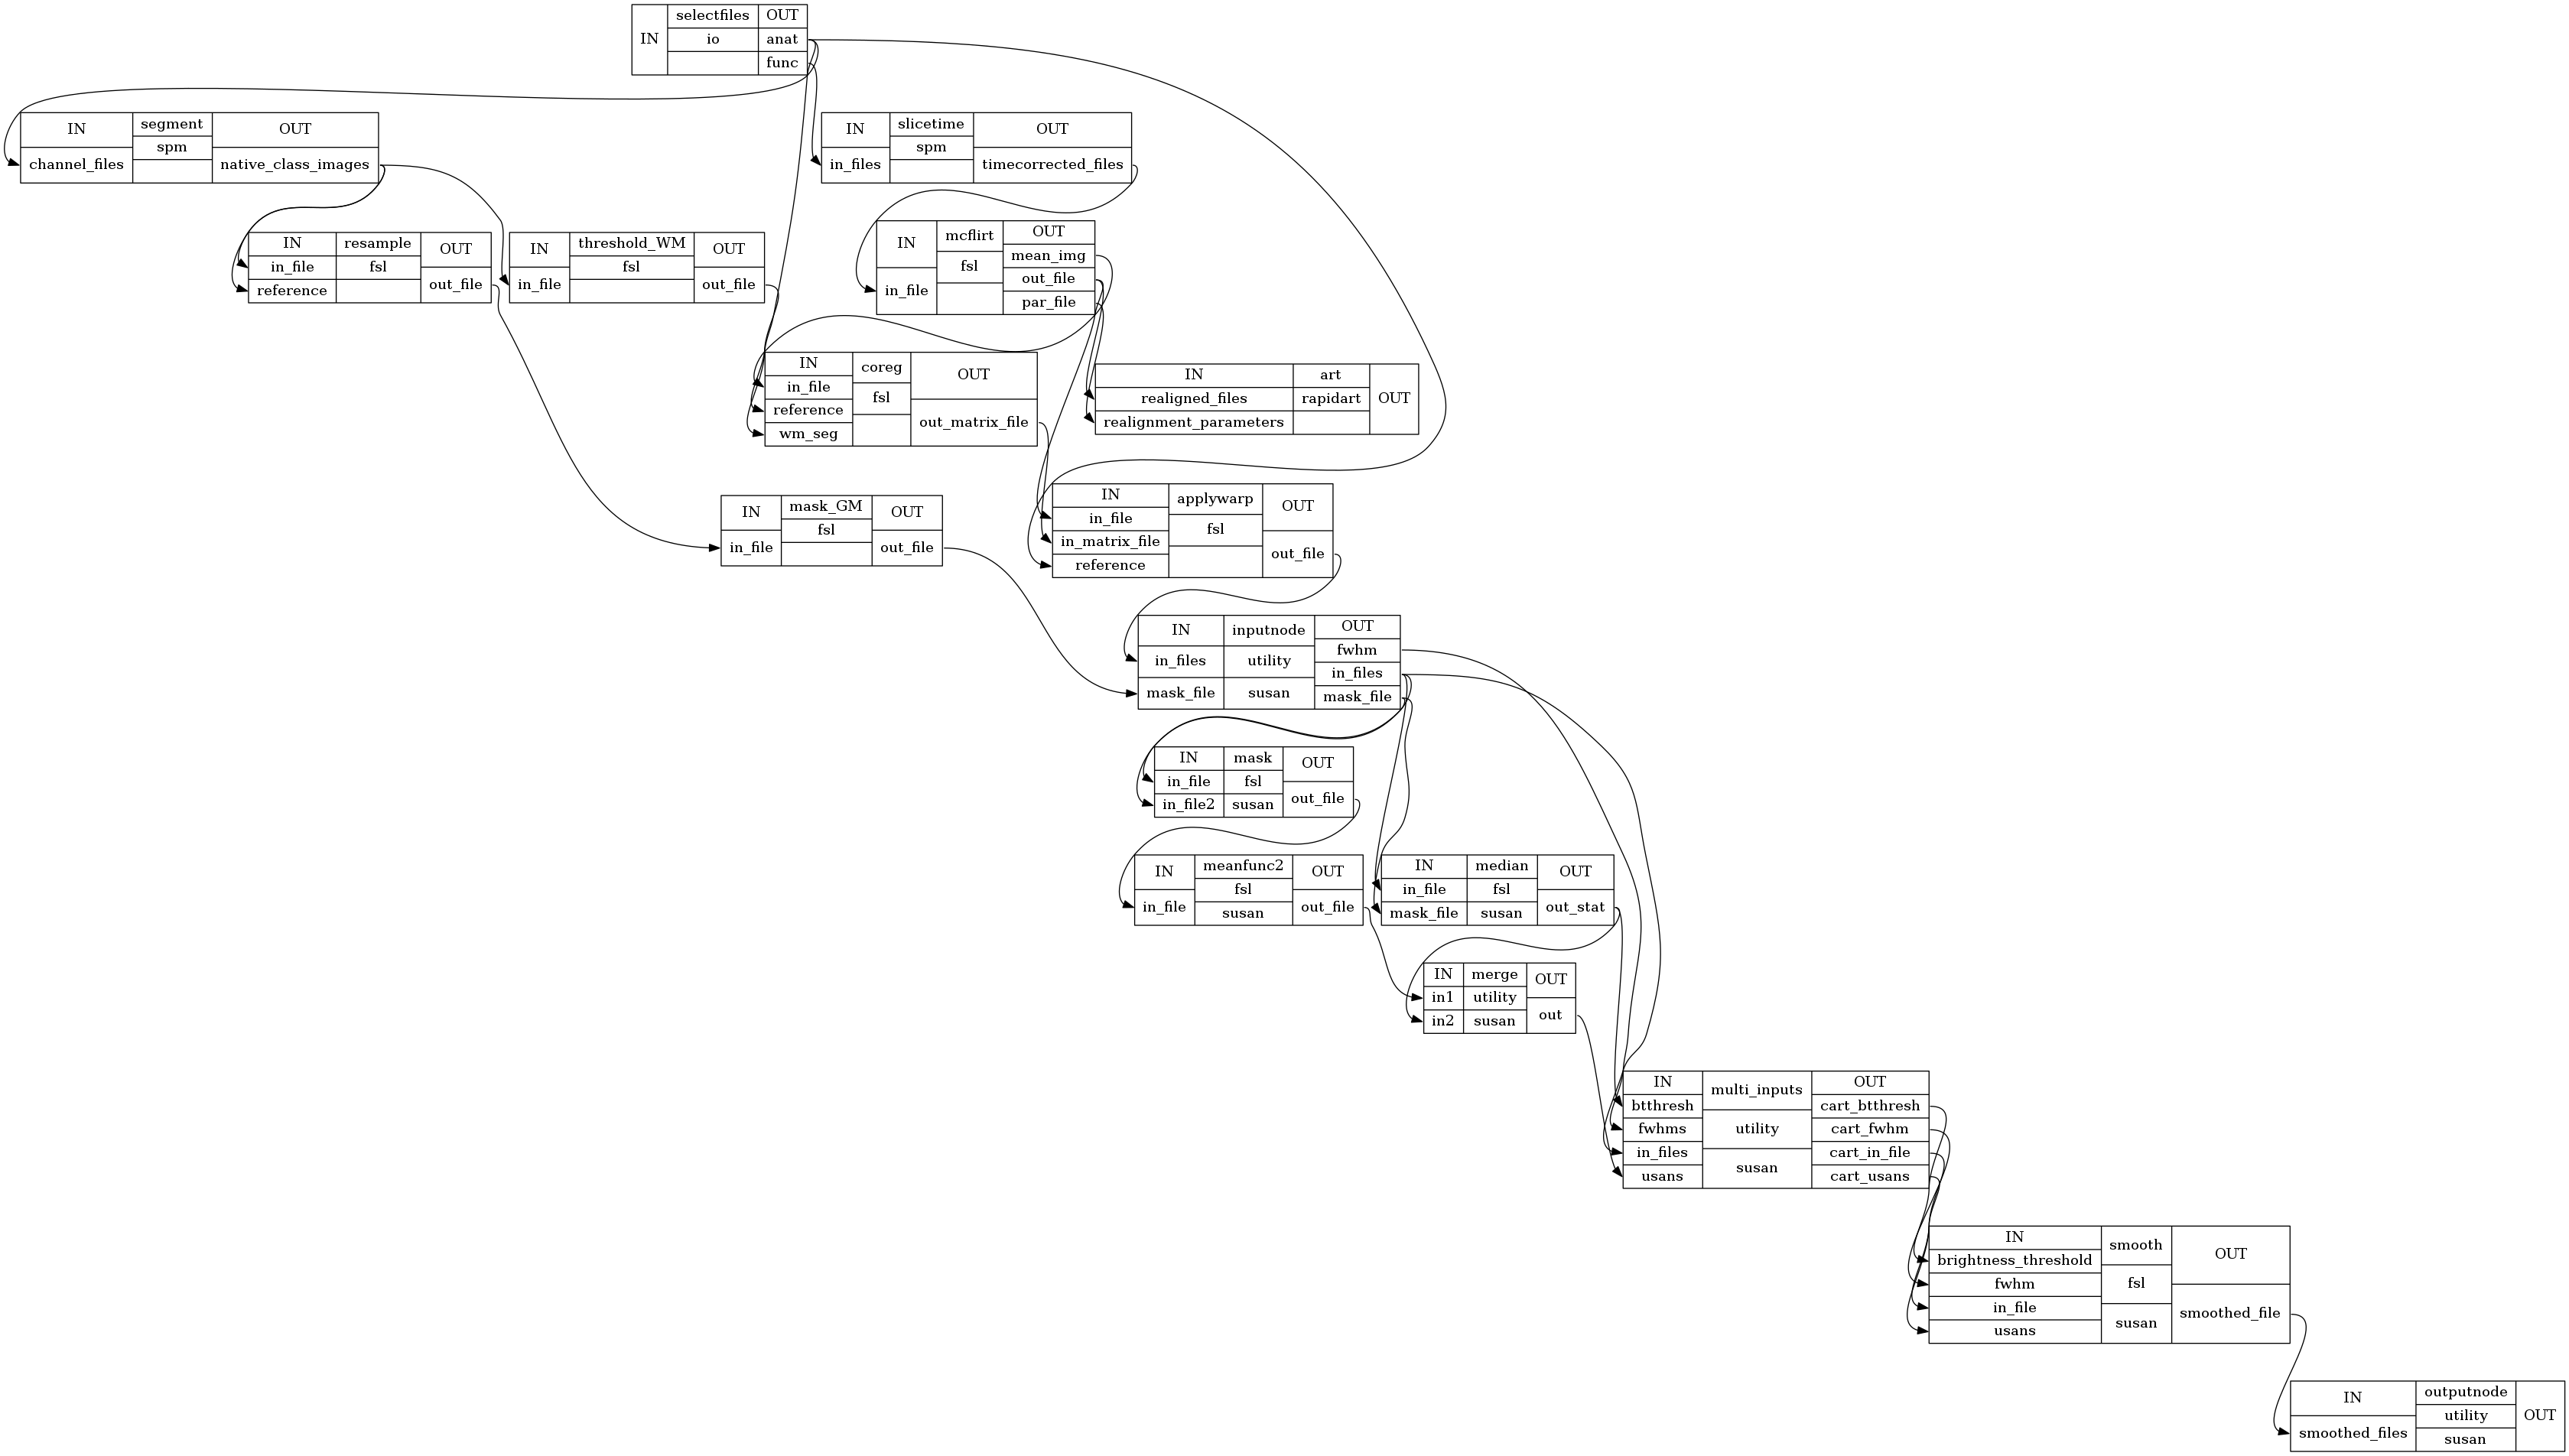

In [73]:
preproc.write_graph(graph2use='flat')
Image('/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/graph_detailed.png')

211113-09:05:53,601 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/graph.png (graph2use=colored, simple_form=True).


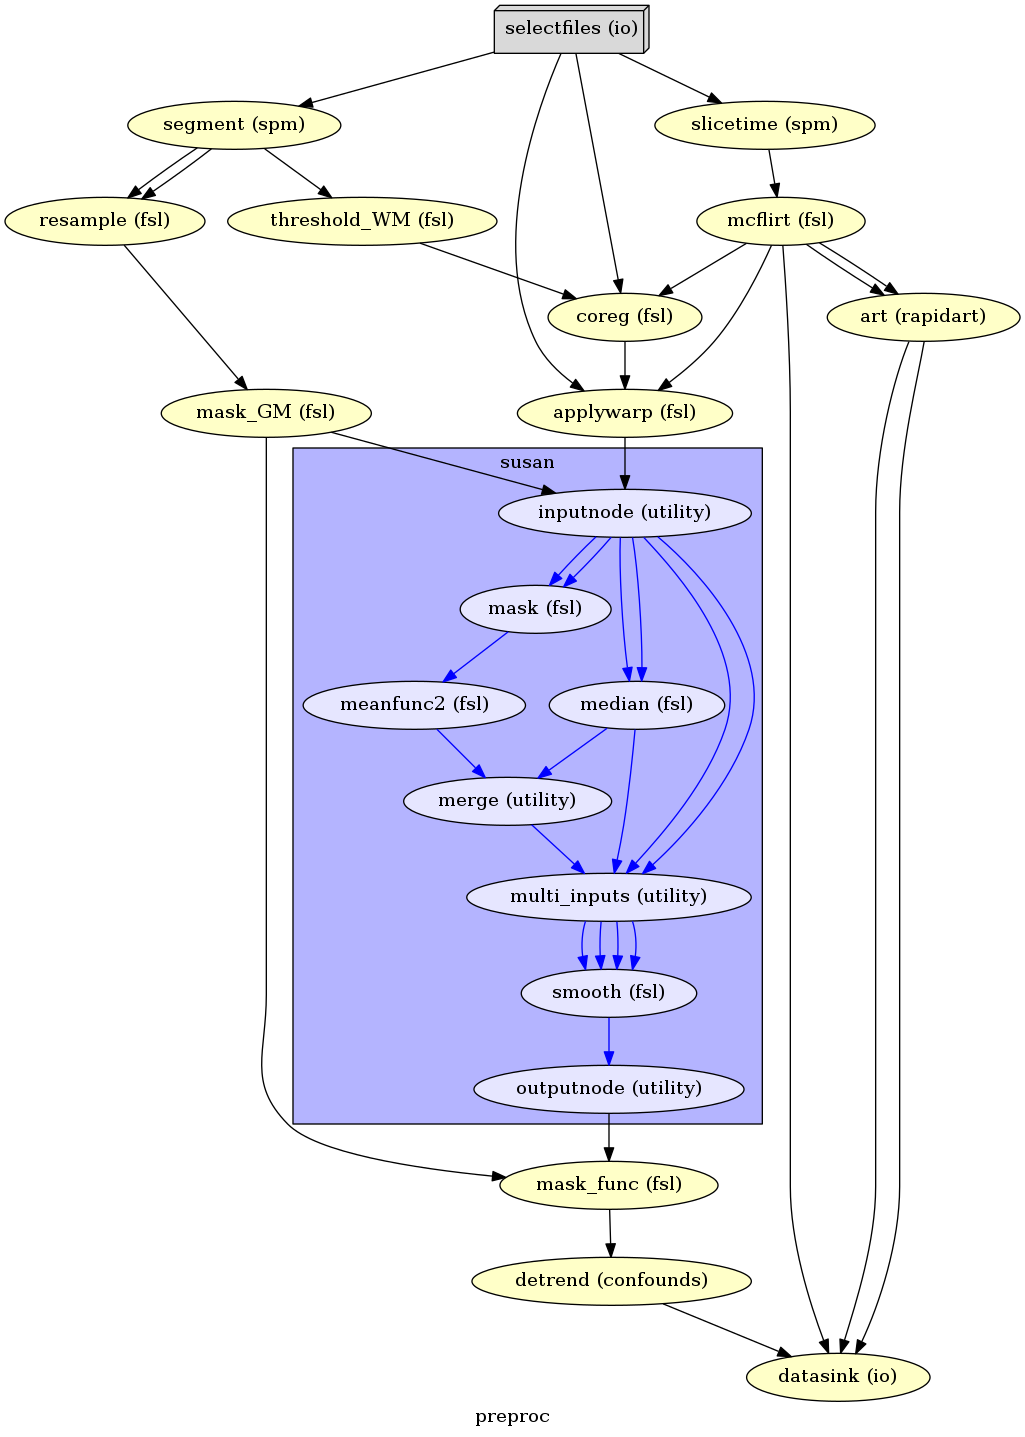

In [110]:
preproc.write_graph(graph2use='colored', format='png', simple_form=True)
Image(filename='/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/graph.png', width=750)

##  Run the Workflow

Now we are ready to run the workflow! Be careful about the `n_procs` parameter if you run a workflow in `'MultiProc'` mode. `n_procs` specifies the number of jobs/cores your computer will use to run the workflow. If this number is too high your computer will try to execute too many things at once and will most likely crash.

**Note**: If  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [121]:
preproc.run('MultiProc', plugin_args={'n_procs': 5})

211113-09:13:21,528 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
211113-09:13:24,338 nipype.workflow INFO:
	 Running in parallel.
211113-09:13:24,361 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 88 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 5/5.
211113-09:13:24,533 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_22_task_id_4/selectfiles".
211113-09:13:24,541 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_22_task_id_3/selectfiles".
211113-09:13:24,558 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_22_task_id_2/selectfiles".
211113-09:13:24,563 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/hom

Process ForkProcess-10:
Process ForkProcess-9:
Process ForkProcess-7:


KeyboardInterrupt: 

Process ForkProcess-8:
Traceback (most recent call last):
exception calling callback for <Future at 0x7fbbaafb9f70 state=finished raised FileNotFoundError>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/src/nipype/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 516, in run
    result = self._run_interface(execute=True)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 635, in _run_interface
    return self._run_command(execute)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 741, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/src/nipype/nipype/interfaces/base/core.py", line 398, in run
    runtime = self._run_interface(runtime)
  File "/src/nipype/nipype/interfaces/base/core.py", line 744, in _run_interface
    runtime = run_command(runtime, output=self.terminal_output)
  F

### Motion Correction and Artifact Detection

How much did the subject move in the scanner and where there any outliers in the functional images?

Text(0, 0.5, 'translation (mm)')

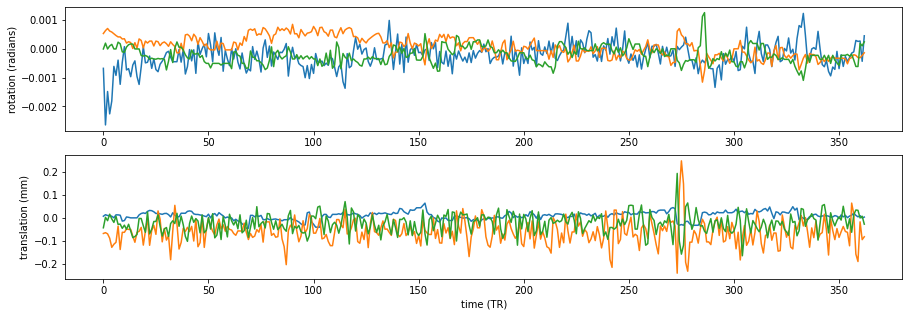

In [87]:
# Plot the motion paramters
par = np.loadtxt('/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_1/mcflirt/asub-07_ses-test_session1_bold_mcf.nii.gz.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)')

The motion parameters seems to look ok. What about the detection of artifacts?

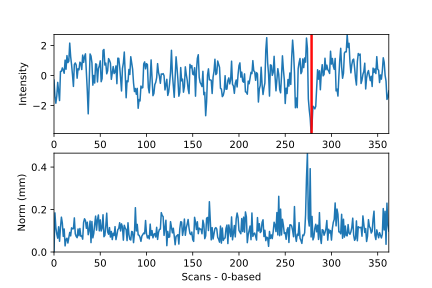

In [88]:
# Showing the artifact detection output
SVG(filename='/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_1/art/plot.asub-07_ses-test_session1_bold_mcf.svg')

In [89]:
outliers = np.loadtxt('/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_1/art/art.asub-07_ses-test_session1_bold_mcf_outliers.txt')
list(outliers.astype('int'))

[278, 279]

### Masks and Probability maps

Let's see what all the masks and probability maps look like. For this, we will use `nilearn`'s `plot_anat` function.

In the figure above, we see that at the very beginning there are extreme values, which hint to the fact that steady state wasn't reached yet. Therefore, we want to exclude the dummy scans from the original data. This can be achieved with FSL's `ExtractROI`.

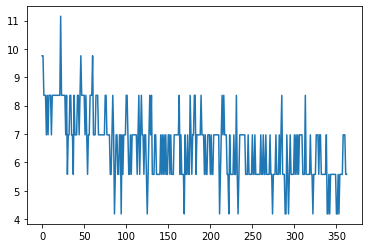

In [90]:
func_file = '/home/neuro/Data/Visual_search_task/BIDS_data/sub-07/ses-test/func/sub-07_ses-test_session1_bold.nii'
plt.plot(nb.load(func_file).get_fdata()[32, 32, 15, :])

In [94]:
output = '/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_1/'
anat = '/home/neuro/Data/Visual_search_task/BIDS_data/sub-07/ses-test/anat/sub-07_ses-test_anat_sT1W.nii'

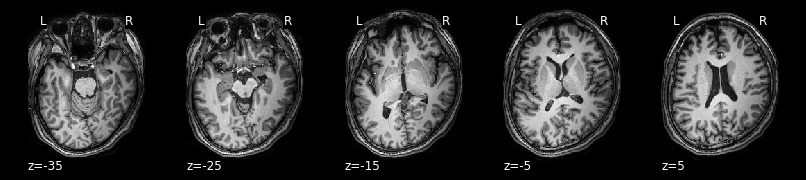

In [92]:
plot_anat(anat, cmap='gray', display_mode='z', cut_coords=range(-35, 15, 10), dim=-1)

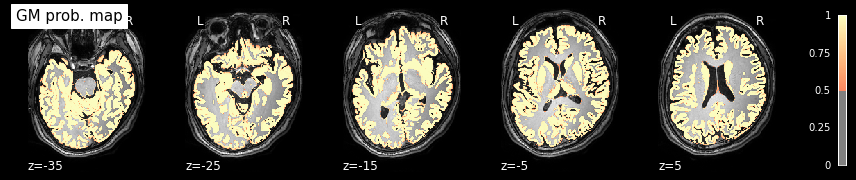

In [95]:
plot_stat_map(output + 'segment/c1sub-07_ses-test_anat_sT1W.nii', title='GM prob. map',  cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-35, 15, 10), dim=-1)

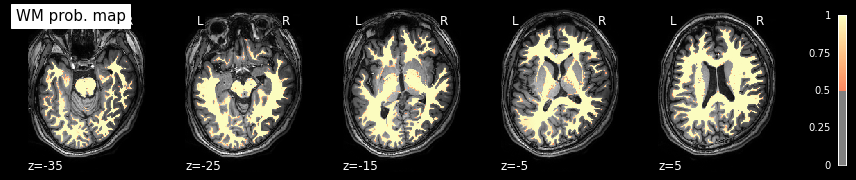

In [96]:
plot_stat_map(
    output + 'segment/c2sub-07_ses-test_anat_sT1W.nii', title='WM prob. map', cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-35, 15, 10), dim=-1);

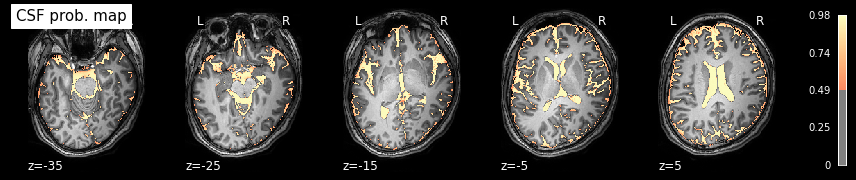

In [97]:
plot_stat_map(
    output + 'segment/c3sub-07_ses-test_anat_sT1W.nii', title='CSF prob. map', cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-35, 15, 10), dim=-1);

And how does the gray matter mask look like that we used on the functional images?

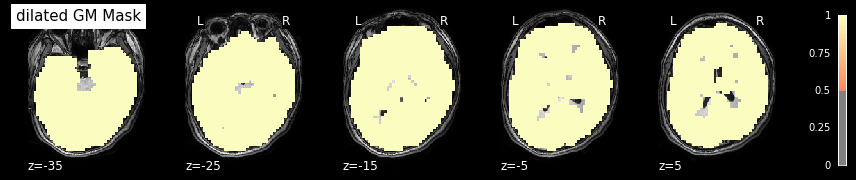

In [98]:
plot_stat_map(
    output + 'mask_GM/c1sub-07_ses-test_anat_sT1W_flirt_thresh.nii', title='dilated GM Mask', cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-35, 15, 10), dim=-1);

### Functional Image transformations

Let's also investigate the transformation that we applied to the functional images.

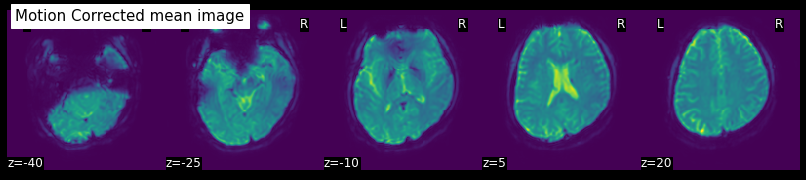

In [99]:
plot_epi(output + 'mcflirt/asub-07_ses-test_session1_bold_mcf.nii.gz_mean_reg.nii.gz',
         title='Motion Corrected mean image', display_mode='z', cut_coords=range(-40, 21, 15),
         cmap=plt.cm.viridis)

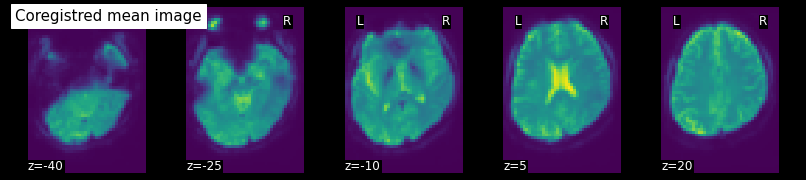

In [100]:
mean = nli.mean_img(output + 'applywarp/asub-07_ses-test_session1_bold_mcf_flirt.nii')
plot_epi(mean, title='Coregistred mean image', display_mode='z', cut_coords=range(-40, 21, 15),
         cmap=plt.cm.viridis)

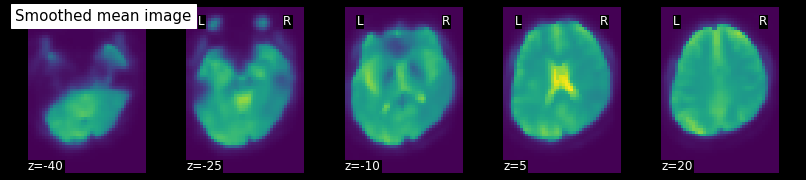

In [101]:
mean = nli.mean_img('/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_07_task_number_1/smooth/mapflow/_smooth0/'
                    'asub-07_ses-test_session1_bold_mcf_flirt_smooth.nii.gz')
plot_epi(mean, title='Smoothed mean image', display_mode='z', cut_coords=range(-40, 21, 15),
         cmap=plt.cm.viridis);

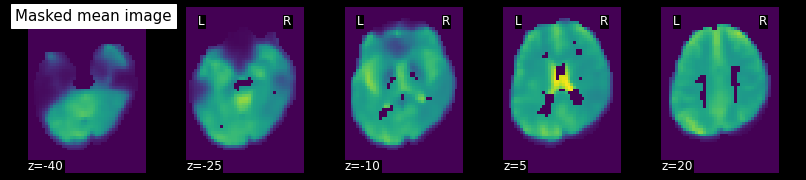

In [102]:
mean = nli.mean_img(output + 'mask_func/mapflow/_mask_func0/'
                    'asub-07_ses-test_session1_bold_mcf_flirt_smooth_masked.nii')
plot_epi(mean, title='Masked mean image', display_mode='z', cut_coords=range(-40, 21, 15),
         cmap=plt.cm.viridis)

That's all nice and beautiful, but what did smoothing and detrending actually do to the data?

/tmp/ipykernel_31933/2165104512.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  plt.plot(mc.get_data()[x, y, z, :])
/tmp/ipykernel_31933/2165104512.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  plt.plot(smooth.get_data()[x, y, z, :])
/tmp/ipykernel_31933/2165104512.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dat

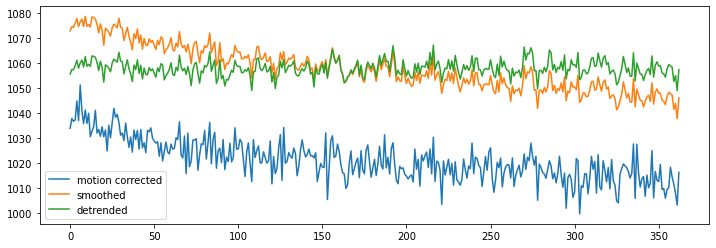

In [105]:
# Load the relevant datasets
mc = nb.load(output + 'applywarp/asub-07_ses-test_session1_bold_mcf_flirt.nii')
smooth = nb.load('/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_07_task_number_1/smooth/mapflow/_smooth0/'
                    'asub-07_ses-test_session1_bold_mcf_flirt_smooth.nii.gz')
detrended_data = nb.load(output + 'detrend/detrend.nii.gz')

# Plot a representative voxel
x, y, z = 32, 34, 43
fig = plt.figure(figsize=(12, 4))
plt.plot(mc.get_data()[x, y, z, :])
plt.plot(smooth.get_data()[x, y, z, :])
plt.plot(detrended_data.get_data()[x, y, z, :])
plt.legend(['motion corrected', 'smoothed', 'detrended']);